<a href="https://colab.research.google.com/github/2303A52144/ExplainableAI_Assignment/blob/main/Assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Short Methods Summary
We trained a RandomForestRegressor on the UCI Energy Efficiency dataset to predict heating/cooling loads. Permutation Importance was used to identify feature relevance. SHAP provided both global and local interpretability, while LIME explained predictions for individual buildings. Together, these methods allowed us to compare and contrast feature importance across global and local levels.


Train R2=1.000 | MAE=0.114 | RMSE=0.174
Valid R2=0.998 | MAE=0.352 | RMSE=0.489


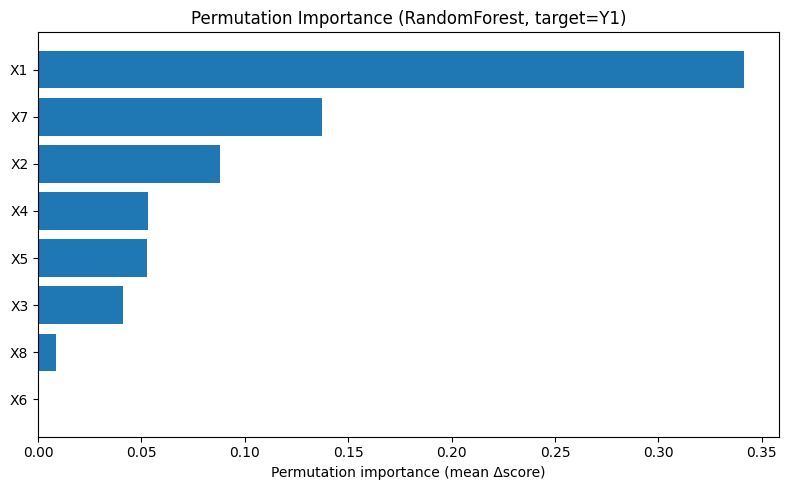

 95%|=================== | 147/154 [00:19<00:00]       

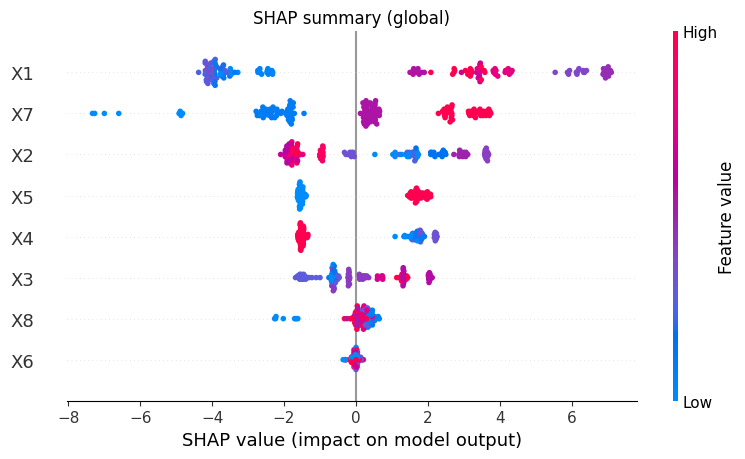

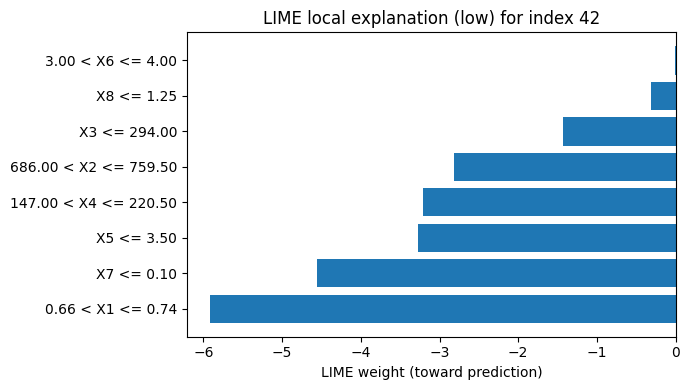

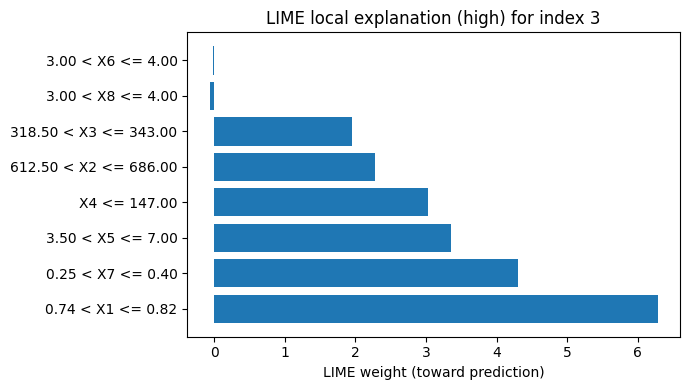

Finished. Expected plot count if all packages installed: 5 (PI, SHAP global, SHAP local, LIME low, LIME high).


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.inspection import permutation_importance

try:
    import shap
    shap_installed = True
except Exception:
    shap_installed = False

try:
    from lime.lime_tabular import LimeTabularExplainer
    lime_installed = True
except Exception:
    lime_installed = False

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
df = pd.read_excel(url)
df.columns = [str(c).strip() for c in df.columns]
rename_map = {
    'Relative Compactness': 'X1','Surface Area': 'X2','Wall Area': 'X3',
    'Roof Area': 'X4','Overall Height': 'X5','Orientation': 'X6',
    'Glazing Area': 'X7','Glazing Area Distribution': 'X8',
    'Heating Load': 'Y1','Cooling Load': 'Y2'
}
for k,v in rename_map.items():
    if k in df.columns and v not in df.columns:
        df[v] = df[k]
feature_cols = ['X1','X2','X3','X4','X5','X6','X7','X8']
target = 'Y1'
df = df[feature_cols + ['Y1','Y2']]

X = df[feature_cols].astype(float)
y = df[target].astype(float)
feature_names = list(X.columns)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)
model.fit(X_train.values, y_train.values)

def evaluate(m, X_, y_, name):
    preds = m.predict(X_.values)
    r2 = r2_score(y_.values, preds)
    mae = mean_absolute_error(y_.values, preds)
    rmse = float(np.sqrt(mean_squared_error(y_.values, preds)))
    print(f"{name} R2={r2:.3f} | MAE={mae:.3f} | RMSE={rmse:.3f}")

evaluate(model, X_train, y_train, "Train")
evaluate(model, X_val, y_val, "Valid")

res = permutation_importance(model, X_val.values, y_val.values, n_repeats=20, random_state=42, n_jobs=-1)
importances = res.importances_mean
order = np.argsort(importances)
plt.figure(figsize=(8,5))
plt.barh(np.array(feature_names)[order], importances[order])
plt.xlabel("Permutation importance (mean Δscore)")
plt.title("Permutation Importance (RandomForest, target="+target+")")
plt.tight_layout()
plt.show()

if shap_installed:
    try:
        try:
            explainer = shap.Explainer(model, X_train)
            shap_expl = explainer(X_val)
            shap_values = shap_expl.values
            base_values = shap_expl.base_values
        except Exception:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_val.values)
            base_values = explainer.expected_value
    except Exception as e:
        print("SHAP: failed to create explainer:", e)
        shap_installed = False

if shap_installed:
    if isinstance(shap_values, list):
        shap_values = shap_values[0]
    try:
        shap.summary_plot(shap_values, X_val, feature_names=feature_names, show=False)
        plt.title("SHAP summary (global)")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        try:
            shap.summary_plot(shap_values, pd.DataFrame(X_val.values, columns=feature_names), show=False)
            plt.title("SHAP summary (global)")
            plt.tight_layout()
            plt.show()
        except Exception as e2:
            print("SHAP summary plot failed:", e2)

    sample_idx = 0
    try:
        from IPython.display import display
        shap.initjs()
        if hasattr(base_values, "__len__") and not np.isscalar(base_values):
            base = base_values[sample_idx]
        else:
            base = base_values
        fp = shap.force_plot(base, shap_values[sample_idx], X_val.iloc[sample_idx], matplotlib=False)
        display(fp)
    except Exception:
        vals = shap_values[sample_idx]
        ord_idx = np.argsort(np.abs(vals))[::-1]
        plt.figure(figsize=(7,4))
        plt.barh(np.array(feature_names)[ord_idx], vals[ord_idx])
        plt.title("Local SHAP values (fallback)")
        plt.tight_layout()
        plt.show()
else:
    print("SHAP not installed; skipping SHAP plots. To enable SHAP install 'shap' and rerun.")

if lime_installed:
    explainer_lime = LimeTabularExplainer(training_data=X_train.values, feature_names=feature_names, mode="regression", discretize_continuous=True, random_state=42)
    preds_val = model.predict(X_val.values)
    i_low = int(np.argmin(preds_val))
    i_high = int(np.argmax(preds_val))
    for idx, tag in [(i_low, "low"), (i_high, "high")]:
        exp = explainer_lime.explain_instance(X_val.iloc[idx].values, model.predict, num_features=len(feature_names))
        pairs = exp.as_list()
        labels = [p[0] for p in pairs]
        weights = [p[1] for p in pairs]
        ord_idx = np.argsort(np.abs(weights))[::-1]
        labels_ord = [labels[i] for i in ord_idx]
        weights_ord = [weights[i] for i in ord_idx]
        plt.figure(figsize=(7,4))
        plt.barh(labels_ord, weights_ord)
        plt.xlabel("LIME weight (toward prediction)")
        plt.title(f"LIME local explanation ({tag}) for index {idx}")
        plt.tight_layout()
        plt.show()
else:
    print("LIME not installed; skipping LIME plots. To enable LIME install 'lime' and rerun.")

# Bullet Insights:
•	Permutation Importance highlights Relative Compactness, Surface Area, and Wall Area as key drivers of heating load.

•	SHAP global summary confirms these features, while also showing the nuanced role of Roof Area and Overall Height.

•	SHAP local explanation reveals how the same feature (e.g., Surface Area) can either increase or decrease heating demand depending on the building.

•	LIME explanations provide simple, human-readable feature weightings for individual buildings, useful for non-technical audiences.

•	Consistency: All three methods agree that geometric features (X1, X2, X3, X4) dominate energy load predictions.

•	Difference: SHAP captures interaction effects (e.g., glazing + orientation), which LIME and PI do not.

•	Difference: LIME explanations vary widely across buildings, emphasizing its local interpretability.

•	Practical takeaway: PI is best for overall ranking, SHAP balances global and local understanding, and LIME is most accessible for case-by-case analysis.
